<a href="https://colab.research.google.com/github/colincockburn/CISC_473_project/blob/main/image_restoration_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Run this cell at start of each session - Change BRANCH name to your working branch.
# if pushing changes to this cell make sure to add them to both notebooks version of it.

import yaml, os
from google.colab import drive

# ==== Team Bootstrap (Colab) ====
# 1) Mount Drive (data only)
drive.mount('/content/drive')

# 2) define consts
REPO_URL  = "https://github.com/colincockburn/CISC_473_project.git"
REPO_DIR  = "/content/drive/MyDrive/projects/CISC_473_project/"
DATA_ROOT = "/content/drive/MyDrive/projects/CISC_473_project_data"


# 3) Clone repo if missing
import os, subprocess, sys
if not os.path.isdir(REPO_DIR):
    os.makedirs(os.path.dirname(REPO_DIR), exist_ok=True)
    print("Cloning repo to", REPO_DIR)
    !git clone "$REPO_URL" "$REPO_DIR"

# 4) Git identity (first time only; uncomment and change to your info)'
# dont push your email and user
%cd $REPO_DIR
!git config user.email ""
!git config user.name ""

# 5) Sync with origin/main and create/update your feature branch
BRANCH = None  # e.g., feature/cc-dataloader
if BRANCH:
  !git fetch origin
  !git checkout main
  !git pull origin main
  !git checkout -B "$BRANCH"
else:
  raise Exception("Please update BRANCH var to your desired working branch")

# 6) Sanity checks
import os
assert os.path.isdir(DATA_ROOT), f"Missing data at: {DATA_ROOT}"
print("OK: repo at", REPO_DIR)
print("OK: data at", DATA_ROOT)
!git status


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/projects/CISC_473_project


Exception: Please update BRANCH var to your desired working branch

In [32]:
# load config and packages
with open(f"{REPO_DIR}/configs/default.yaml", "r") as f:
    cfg = yaml.safe_load(f)

from src.data import Div2kDataSet


In [33]:
data_root = cfg["paths"]["data_root"]
ds_train = Div2kDataSet(root=data_root, split="train", patch_size=128, sigma=25, augment=True)
ds_val = Div2kDataSet(root=data_root, split="valid", patch_size=128, sigma=25, augment=False)
print("Total train images:", len(ds_train)) # 800
print("Total val images:", len(ds_val))     # 100


Total train images: 800
Total val images: 100


In [34]:
import torch
from torch.utils.data import DataLoader
# test data pipeline
loader = DataLoader(ds_train, batch_size=cfg["data"]["batch_size"], shuffle=True)
xb, yb = next(iter(loader))
print("output:   batch:", xb.shape, yb.shape, "nan?", torch.isnan(xb).any().item(), "inf?", torch.isinf(xb).any().item())


output:   batch: torch.Size([16, 3, 128, 128]) torch.Size([16, 3, 128, 128]) nan? False inf? False


In [35]:
# Item Sanity
ds = Div2kDataSet(root=data_root, split="train", patch_size=128, sigma=25, augment=True)
noisy, clean = ds[0]
print("shapes:", noisy.shape, clean.shape)     # (3,128,128)
print("ranges:", (float(noisy.min()), float(noisy.max())),
                 (float(clean.min()), float(clean.max())))
print("noise mean abs:", float((noisy-clean).abs().mean()))


shapes: torch.Size([3, 128, 128]) torch.Size([3, 128, 128])
ranges: (0.0, 0.8927843323201681) (0.0, 0.7137255072593689)
noise mean abs: 0.06367684492657193


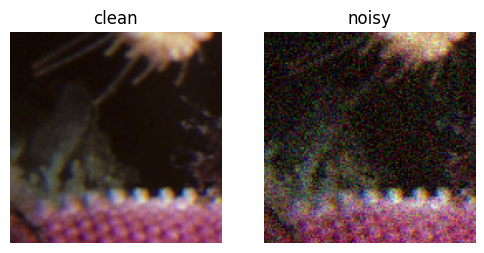

In [36]:
# visual sanity check
import matplotlib.pyplot as plt
def show(t, title): plt.imshow(t.permute(1,2,0).numpy()); plt.title(title); plt.axis('off')
noisy, clean = ds[0]
plt.figure(figsize=(6,3)); plt.subplot(1,2,1); show(clean,"clean")
plt.subplot(1,2,2); show(noisy,"noisy"); plt.show()
